In [ ]:
! pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 47.9 MB/s 
     |████████████████████████████████| 287 kB 86.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#import contractions
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.optim as optim


import matplotlib.pyplot as pltA
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

from collections import Counter, OrderedDict
from itertools import chain
import torch
from tqdm import tqdm
import warnings

import torchtext

import math
import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn import (TransformerEncoder, TransformerDecoder,TransformerEncoderLayer, TransformerDecoderLayer)
import io
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Cleaned_Data.csv')

In [ ]:
data['summary'] = data['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
train_data=data[:10000]
test_data=data[1000:2500]


In [ ]:
### Building the model -Tensorflow

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(train_data['article']))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(train_data['article']) 
x_val   =   x_tokenizer.texts_to_sequences(test_data['article'])

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=350, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=350, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(train_data['summary']))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(train_data['summary']) 
y_val   =   y_tokenizer.texts_to_sequences(test_data['summary']) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=40, padding='post')
y_val   =   pad_sequences(y_val, maxlen=40, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
from attention import AttentionLayer

In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(350,))
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_out1, state_h1, state_c1 = encoder_1(enc_emb) 

#LSTM 2 
encoder_2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_out2, state_h2, state_c2 = encoder_2(encoder_out1) 

#LSTM 3 
encoder_3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_out3, state_h, state_c= encoder_3(encoder_out2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_out3, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 350, 500)     44704500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 350, 500),   2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
y_tr.shape

(10000, 40)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
79/79 [==============================] - 182s 2s/step - loss: 6.8346 - val_loss: 6.1251
Epoch 2/50
79/79 [==============================] - 174s 2s/step - loss: 6.1465 - val_loss: 6.0080
Epoch 3/50
79/79 [==============================] - 174s 2s/step - loss: 6.0566 - val_loss: 5.9291
Epoch 4/50
79/79 [==============================] - 175s 2s/step - loss: 5.9742 - val_loss: 5.8323
Epoch 5/50
79/79 [==============================] - 176s 2s/step - loss: 5.8620 - val_loss: 5.6597
Epoch 6/50
79/79 [==============================] - 176s 2s/step - loss: 5.7058 - val_loss: 5.4687
Epoch 7/50
79/79 [==============================] - 176s 2s/step - loss: 5.5292 - val_loss: 5.2674
Epoch 8/50
79/79 [==============================] - 177s 2s/step - loss: 5.3333 - val_loss: 5.0305
Epoch 9/50
79/79 [==============================] - 177s 2s/step - loss: 5.1158 - val_loss: 4.8087
Epoch 10/50
79/79 [==============================] - 178s 2s/step - loss: 4.8888 - val_loss: 4.5228
Epoch 11/

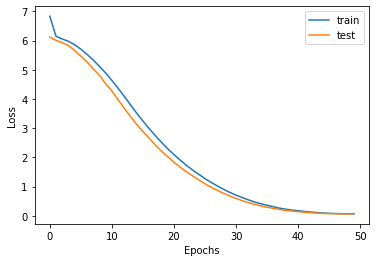

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.legend() 
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_out3, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(350,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
max_text_len=350
max_summary_len=40

In [ ]:
reverse_target_word_index[310]

'much'

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        print(output_tokens)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index+1]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [ ]:
df=pd.DataFrame(columns=['original_summary','predicted_summary'])

In [ ]:
pred_dic={}
test_dic={}
for i in range(0,5):
    print("Review:",seq2text(x_tr[i]))
    print("original summary:",seq2summary(y_tr[i]))
    df.loc[i,'original_summary']=seq2summary(y_tr[i])
    print("predicted summary:",decode_sequence(x_tr[i].reshape(1,350)))
    predicted=decode_sequence(x_tr[i].reshape(1,350))
    df.loc[i,'predicted_summary']=predicted
    print("\n")

Review: associated press published october 2013 updated october 2013 bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis state immunization program manager molly howell says risk officials feel important alert people possible exposure diocese announced monday bishop john folda taking time diagnosed hepatitis diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota pictured bishop located 
original summary: bishop john folda north dakota taking time diagnosed contracted in

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'index':'id'},inplace=True)
df

,id,id,original_summary,predicted_summary
0,0,0,bishop john folda north dakota taking time diagnosed contracted infection contaminated food italy church members fargo grand forks jamestown could exposed,cafe minister fargo another contaminated morning family data suits port isle incident squad teenager goal forks hearing jamestown assassins people keeping says sostok sostok sostok sostok sostok ...
1,1,1,criminal complaint used role help cocaine traffickers ralph mata internal affairs lieutenant allegedly helped group guns also arranged assassins murder plot complaint alleges,crown larger south evidence state tested nina lieutenant trick raising arranged hispanic came risk arrested plot years alleges eccleston head wore larger bradford says sostok sostok sostok sostok...
2,2,2,eccleston todd drunk least three pints driving using phone veered across road yarmouth isle wight crashed head year rachel titley died hospital police would legal drink drive limit time crash foun...,news home called forces drive road drive lived thought residents road drive road poyet found player trial lived drive found family factories says sostok sostok sostok sostok sostok sostok sostok ...
3,3,3,nina santos says europe must ready accept sanctions hurt sides targeting russia business community would sapping support president putin says says europe would hard time keeping factories going wi...,laboratory draws year business calls target bigger sarah gaal firms enjoying role prime talks time scunthorpe friends told performance year year business time beach family counter fleetwood owner...
4,4,4,league scunthorpe peterborough bristol city chesterfield crawley drop first points season stand striker matt done scores trick rochdale thrash crewe wins notts county yeovil coventry bradford oldh...,suggests released perception telford passenger much yeovil ship jack passenger agreement comment confirmed lawyers days position front days suggests firm vale firm debut issues tough says sostok ...


In [ ]:
df.to_csv('Predictions.csv')

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 15.1 MB/s 
     |████████████████████████████████| 132 kB 83.4 MB/s 
     |████████████████████████████████| 182 kB 83.6 MB/s 
     |████████████████████████████████| 212 kB 103.5 MB/s 
     |████████████████████████████████| 127 kB 66.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
#### Bleu Score
from datasets import load_metric
  
bleu = load_metric("bleu")


In [ ]:
def token(x):
  train_egs=[]
  words = x.split()
  for i in words:
    train_egs.append(i)
  return train_egs

In [ ]:
train_lst=[]

In [ ]:
for i in range(len(train_data)):
  val=token(train_data.iloc[i][2])
  train_lst.append(val)
# train_lst

In [ ]:
predicted_lst=[]
predicted_lst.append(token(predicted))

In [ ]:
final=[]
for i in predicted_lst:
  for j in i:
    if j !='sostok':
      final.append(j)


In [ ]:
predicted_lst.append(final)
del predicted_lst[0]

In [ ]:

train_final=[]
train_final.append(train_lst)


In [ ]:

from nltk.translate.bleu_score import corpus_bleu

references = train_final
candidates = predicted_lst
score = corpus_bleu(references, candidates)

In [ ]:
score

1.804055893291758e-231